In [1]:
import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

import cPickle as pkl
from scipy import stats as spstats

from pipeline.python.classifications import responsivity_stats as resp
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import get_dataset_stats as ds
from pipeline.python.utils import natural_keys, label_figure

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

In [2]:
from pipeline.python.retinotopy import convert_coords as cc


In [3]:
# Set output dir:

In [4]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

In [5]:
rfdir = os.path.join(aggregate_dir, 'rfs')
if not os.path.exists(rfdir):
    os.makedirs(rfdir)

In [6]:
#reload(fitrf)

In [10]:
rootdir = '/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
response_type = 'dff'
traceid='traces001'
trace_type= 'corrected'
responsive_test = 'ROC'
fit_thr=0.5

In [11]:
fit_desc = fitrf.get_fit_desc(response_type=response_type)
print(fit_desc)

fit-2dgaus_dff-no-cutoff


In [12]:
data_desc = '-'.join([traceid, trace_type, response_type, responsive_test])

data_identifier = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print(data_identifier)

traces001-corrected-dff-ROC|fit-2dgaus_dff-no-cutoff-thr-0.50


In [13]:
sdata = ds.aggregate_session_info()

[JC084] Li - skipping
[JC091] V1 - skipping
[JC085] Lm - skipping
[JC085] Li - skipping
[JC090] V1 - skipping
[JC090] Lm - skipping
[JC099] V1 - skipping
[JC099] Lm - skipping
[JC097] Lm - skipping
[JC097] Li - skipping
[JC078] V1 - skipping
[JC078] Li - skipping
[JC080] V1 - skipping
[JC083] Li - skipping


In [14]:
sdata.head()

,animalid,experiment,fov,session,visual_area
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1
3,JC084,retino,FOV1_zoom2p0x,20190522,V1
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm


In [15]:
sdata['experiment'].unique()

array(['rfs', 'gratings', 'blobs', 'retino', 'rfs10'], dtype=object)

In [16]:
sdata[sdata['experiment'].isin(['rfs', 'rfs10'])].shape

(39, 5)

In [17]:
rf_sdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
fit_these = []
dpaths = []
unknown = []
for animalid in rf_sdata['animalid'].unique():
    sessions = rf_sdata[rf_sdata['animalid']==animalid]['session'].unique()
    for session in sessions:
        rfruns = rf_sdata[(rf_sdata['animalid']==animalid) & (rf_sdata['session']==session)]['experiment'].unique()
        fovs = rf_sdata[(rf_sdata['animalid']==animalid) & (rf_sdata['session']==session)]['fov'].unique()
        for fov in fovs:
            for rfname in rfruns:
                if int(session) < 20190511:
                    f = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                                'combined_gratings*', 'traces', '%s*' % traceid, 
                                                'receptive_fields', fit_desc, 'fit_results.pkl'))
                else:
                    f = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                                'combined_%s*' % rfname, 'traces', '%s*' % traceid, 
                                                'receptive_fields', fit_desc, 'fit_results.pkl'))
                if len(f) > 0:
                    for fi in f:
                        if fi not in dpaths:
                            dpaths.append(fi)
                elif len(f) == 0:
                    fit_these.append((animalid, session, fov, rfname))
                else:
                    unknown.append((animalid, session, fov, rfname))
            

In [18]:
rf_sdata.tail()

,animalid,experiment,fov,session,visual_area
108,JC083,rfs,FOV1_zoom2p0x,20190507,V1
109,JC083,rfs,FOV1_zoom2p0x,20190511,V1
113,JC083,rfs,FOV1_zoom2p0x,20190512,Lm
117,JC083,rfs,FOV1_zoom2p0x,20190517,Lm
123,JC083,rfs,FOV1_zoom2p0x,20190508,Lm


In [19]:
rf_sdata['path'] = dpaths

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
for (animalid, session, fov, run_name) in fit_these:
    nostats = resp.visualize_session_stats(animalid, session, fov, altdir=aggregate_session_dir, create_new=True)

In [21]:
len(dpaths)

39

In [22]:
assert (len(dpaths) + len(fit_these) + len(unknown)) == rf_sdata.shape[0]

In [23]:
# Load session stats for relevant datasets

In [24]:
rf_sdata.head()

,animalid,experiment,fov,session,visual_area,path
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0...
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0...
8,JC091,rfs,FOV1_zoom2p0x,20190627,Lm,/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0...
12,JC091,rfs10,FOV1_zoom2p0x,20190607,Li,/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...
16,JC091,rfs10,FOV1_zoom2p0x,20190614,Li,/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0...


In [27]:
fit_thr = 0.5

df_list = []
for visual_area in ['V1', 'Lm', 'Li']:
    #df_list = []

    #visual_area = 'V1'
    for fpath in rf_sdata[rf_sdata['visual_area']==visual_area]['path']:

        parentdir = fpath.split('/traces')[0]
        run_name = os.path.split(parentdir)[-1]
        fov = os.path.split(os.path.split(parentdir)[0])[-1]
        session = os.path.split(parentdir.split('/%s' % fov)[0])[-1]
        animalid = os.path.split(parentdir.split('/%s' % session)[0])[-1]

        with open(fpath,'rb') as f:
            rfits = pkl.load(f)

        roi_list = [r for r, res in rfits['fit_results'].items() if res['fit_r']['r2'] >= fit_thr]
        fitdf = fitrf.rfits_to_df(rfits['fit_results'], 
                                row_vals=rfits['row_vals'],
                                col_vals=rfits['col_vals'],
                                roi_list=sorted(roi_list))
        nsamples = fitdf.shape[0]
        fitdf['cell'] = fitdf.index.tolist()
        fitdf['animalid'] = [animalid for _ in range(nsamples)]
        fitdf['session'] = [session for _ in range(nsamples)]
        fitdf['visual_area'] = [visual_area for _ in range(nsamples)]
        fitdf['fov'] = [fov for _ in range(nsamples)]

        df_list.append(fitdf)

    #dfs[visual_area] = pd.concat(df_list, axis=0).reset_index()

In [28]:
df = pd.concat(df_list, axis=0).reset_index()

In [29]:
df.groupby(['visual_area']).count()

,index,r2,sigma_x,sigma_y,theta,x0,y0,cell,animalid,session,fov
visual_area,,,,,,,,,,,
Li,502,502,502,502,502,502,502,502,502,502,502
Lm,439,439,439,439,439,439,439,439,439,439,439
V1,1277,1277,1277,1277,1277,1277,1277,1277,1277,1277,1277


In [30]:
sigma_scale = 2.35

In [31]:
df['sigma_x'] = df['sigma_x']*sigma_scale
df['sigma_y'] = df['sigma_y']*sigma_scale


In [32]:
df['avg_size'] = df[['sigma_x', 'sigma_y']].mean(axis=1)

In [34]:
%matplotlib notebook

<IPython.core.display.Javascript object>


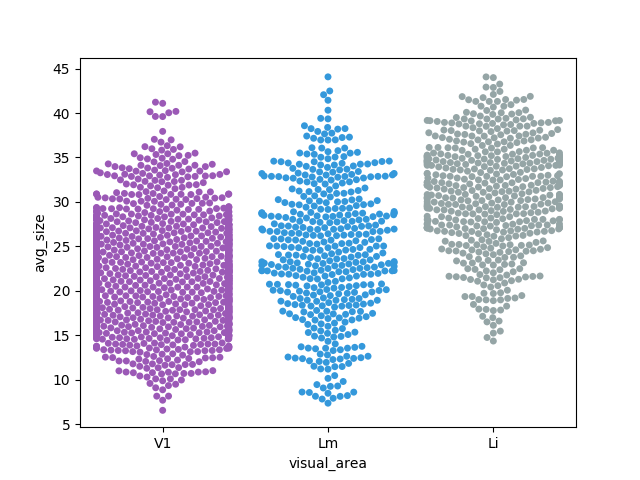

In [35]:
pl.figure()
sns.swarmplot(x="visual_area", y="avg_size", data=df)

In [127]:
df[df['visual_area']==visual_area].shape

(502, 13)

In [36]:
visual_area

'Li'

In [37]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'


In [38]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

<IPython.core.display.Javascript object>


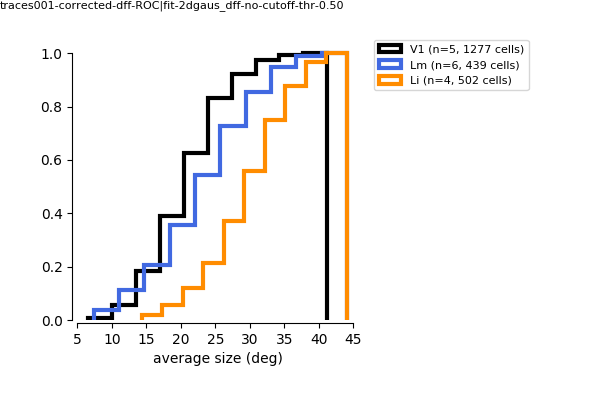

In [39]:
fig, ax = pl.subplots(figsize=(6,4))
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(df[df['visual_area']==visual_area]['animalid'].unique())
    ncells_total = df[df['visual_area']==visual_area].shape[0]
    values = df[df['visual_area']==visual_area]['avg_size'].values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('average size (deg)')
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'cdf_average_rf_size.png'))

<IPython.core.display.Javascript object>


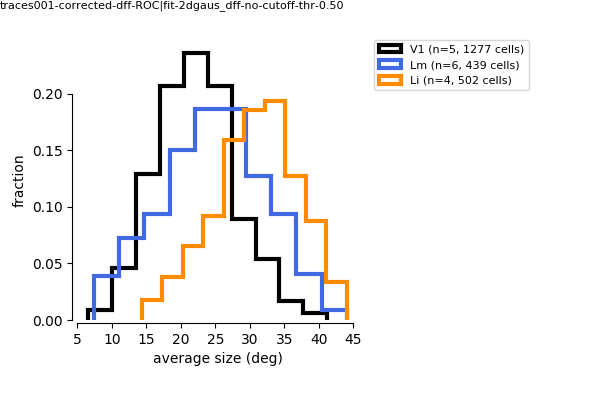

In [178]:
fig, ax = pl.subplots(figsize=(6,4))
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(df[df['visual_area']==visual_area]['animalid'].unique())
    ncells_total = df[df['visual_area']==visual_area].shape[0]
    values = df[df['visual_area']==visual_area]['avg_size'].values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=False,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('average size (deg)')
ax.set_ylabel('fraction')
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'hist_average_rf_size.png'))

In [40]:
visual_area = 'V1' 
d = df[df['visual_area']==visual_area]


In [42]:
d.head()

,index,r2,sigma_x,sigma_y,theta,x0,y0,cell,animalid,session,visual_area,fov,avg_size
0,0,0.734225,15.872766,23.564779,1.533098,24.776422,-11.469018,0.0,JC084,20190522,V1,FOV1_zoom2p0x,19.718773
1,2,0.520136,16.516020,19.051182,-0.523212,32.432005,-11.544950,2.0,JC084,20190522,V1,FOV1_zoom2p0x,17.783601
2,5,0.552829,18.949260,27.004408,-1.426131,17.836423,-12.234272,5.0,JC084,20190522,V1,FOV1_zoom2p0x,22.976834
3,9,0.852096,23.878438,19.566025,-0.027895,24.116823,-11.728018,9.0,JC084,20190522,V1,FOV1_zoom2p0x,21.722232
4,11,0.869807,21.945404,16.465211,0.250786,21.851019,-11.102363,11.0,JC084,20190522,V1,FOV1_zoom2p0x,19.205308


In [43]:
reload(cc)

<module 'pipeline.python.retinotopy.convert_coords' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/convert_coords.pyc'>

In [44]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = cc.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = cc.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


In [48]:
pos_list = []
for visual_area in visual_areas:
    d = df[df['visual_area']==visual_area]
    for (animalid, session, fov), g in d.groupby(['animalid', 'session', 'fov']):
        rffits = g.copy()
        rffits.index = g['index']
        posdf = get_fov_coordinates(animalid, session, fov, rffits)
        pos_list.append(posdf)


[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
... loading data array (combined_gratings_static - datasets.npz)
... loaded
... offset: 251.51
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 300 contours for rois.
[JC076] 20190501 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190501|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment 

Created 323 contours for rois.
[JC078] 20190430 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
... loading data array (combined_gratings_static - datasets.npz)
... loaded
... offset: 624.53
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 293 contours for rois.
[JC078] 20190504 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC078|20190504|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_

... offset: 513.66
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 226 contours for rois.
[JC090] 20190605 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC090|20190605|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... ... combined_rfs10_static
... renaming experiment to run name: combined_rfs10_static
... loading data array (combined_rfs10_static - datasets.npz)
... loaded
... offset: 398.90
... making equal
Checking counts / condition...
... updating self
... ... loaded traces
Created 271 contours for rois.
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190602|FOV1_z

In [53]:
posdf = pd.concat(pos_list, axis=0).reset_index()


In [54]:
posdf.head()

,index,animalid,fov,session,visual_area,xpos_fov,xpos_rf,ypos_fov,ypos_rf
0,5,JC076,FOV1_zoom2p0x,20190420,V1,41.969973,45.590696,273.349886,5.655262
1,7,JC076,FOV1_zoom2p0x,20190420,V1,267.081644,34.002847,125.092321,1.460737
2,24,JC076,FOV1_zoom2p0x,20190420,V1,129.725370,40.360602,356.744767,4.182264
3,25,JC076,FOV1_zoom2p0x,20190420,V1,120.186740,43.581691,403.075256,2.775072
4,26,JC076,FOV1_zoom2p0x,20190420,V1,146.894904,43.078912,379.910012,2.955575


In [55]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [56]:
with open(os.path.join(aggregate_dir, 'rfs', 'rf_positions.pkl'), 'wb') as f:
    pkl.dump(posdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [60]:
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats

def calculate_distance(df):
    
    regr = LinearRegression()
    xv = np.array(df['ypos_fov']).reshape(-1, 1) 
    yv = np.array(df['xpos_rf']).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['dist_az'] = yv - fitv

        
    regr = LinearRegression()
    xv = np.array(df['xpos_fov']).reshape(-1, 1) 
    yv = np.array(df['ypos_rf']).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['dist_el'] = yv - fitv
    
    return df

In [65]:
pf = pd.concat([calculate_distance(g) for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0).reset_index(drop=True)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
pf.head()

,index,animalid,fov,session,visual_area,xpos_fov,xpos_rf,ypos_fov,ypos_rf,dist_az,dist_el
0,5,JC076,FOV1_zoom2p0x,20190420,V1,41.969973,45.590696,273.349886,5.655262,10.666164,5.486368
1,7,JC076,FOV1_zoom2p0x,20190420,V1,267.081644,34.002847,125.092321,1.460737,-1.849990,1.593305
2,24,JC076,FOV1_zoom2p0x,20190420,V1,129.725370,40.360602,356.744767,4.182264,5.958242,4.130889
3,25,JC076,FOV1_zoom2p0x,20190420,V1,120.186740,43.581691,403.075256,2.775072,9.469426,2.710924
4,26,JC076,FOV1_zoom2p0x,20190420,V1,146.894904,43.078912,379.910012,2.955575,8.821600,2.927193


<IPython.core.display.Javascript object>


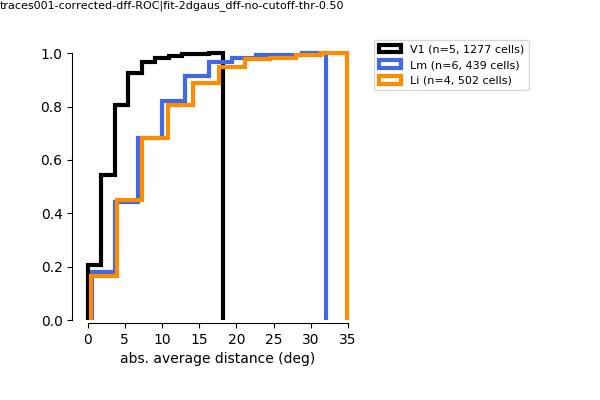

In [80]:
fig, ax = pl.subplots(figsize=(6,4), sharey=True)
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(pf[pf['visual_area']==visual_area]['animalid'].unique())
    ncells_total = pf[pf['visual_area']==visual_area].shape[0]

    values = abs(pf[pf['visual_area']==visual_area][['dist_el', 'dist_az']]).mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('abs. average distance (deg)')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'cdf_average_distance_from_regr.png'))

<IPython.core.display.Javascript object>


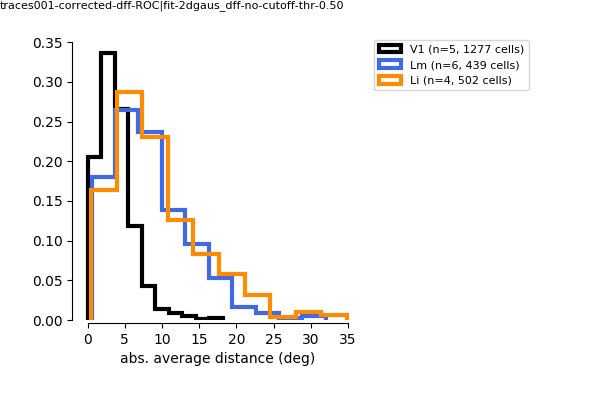

In [81]:
fig, ax = pl.subplots(figsize=(6,4), sharey=True)
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(pf[pf['visual_area']==visual_area]['animalid'].unique())
    ncells_total = pf[pf['visual_area']==visual_area].shape[0]

    values = abs(pf[pf['visual_area']==visual_area][['dist_el', 'dist_az']]).mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=False,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('abs. average distance (deg)')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfdir, 'hist_average_distance_from_regr.png'))

In [ ]:
abs(pf[pf['visual_area']==visual_area][['dist_el', 'dist_az']]).mean(axis=1).values